# COMP41680 Assignment 2

##### Student name: Aditi Bansal 
##### Student no: 19200465

### Import Packages etc

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

# Task 1: Scraping reviews and storing them with class labels

I have chosen three categories as fashion, gym and hair & salon to scrape consumer reviews and evaluate the performance of text classification algorithms on these categories data. 

Since each category page has links for consumer reviews and ratings, I first scrapped all the href tags from the category page content to further extract reviews and ratings from those links. The web scraping has been done using BeautifulSoup package. After scraping all the href tags which are inside anchor tags of page, I stored them in separate lists for each category. 

I have created a function called get_url to perform this task so that we don't have to repeatedly perform the same link extraction task for each category.

In [2]:
def  get_url(href):
    
    homepage_url = 'http://mlg.ucd.ie/modules/yalp/'
    
    #empty list to store urls from the category
    category_url = []
    
    # getting the reponse from the page of category using get method of requests module
    response = requests.get(href)
    
    # storing the source code from webpage of the category
    content = response.text
    
    #creating BeautifulSoup object to parse the source code
    bsoup = BeautifulSoup(content, "html.parser")
    
    # Extracting only urls from the category
    category_url =[homepage_url+ tags.get("href") for tags in bsoup.find_all("a")]
    
    return category_url
    

# Fetching category links
fashion_href = 'http://mlg.ucd.ie/modules/yalp/fashion_list.html'
gym_href = 'http://mlg.ucd.ie/modules/yalp/gym_list.html'
hair_salon_href = 'http://mlg.ucd.ie/modules/yalp/hair_salons_list.html'

#empty lists to store urls from the categories
fashion_url = []
gym_url = []
hair_salon_url = []

#Calling function to get fashion category urls 
fashion_url = get_url(fashion_href)

#Calling function to get gym category urls 
gym_url = get_url(gym_href)

#Calling function to get hair & salon category urls 
hair_salon_url = get_url(hair_salon_href)

### Reviews and Ratings Extraction

I have now extracted reviews and ratings from every link given on the category page and stored them in a dataframe for each category with class labels for each review as either negative for star rating from 1-3 or positive for star rating from 4-5. I have scrapped the ratings data from alt tag under image tag which has ratings in the form of nos from 1-5. I have done this by creating a function called review_ratings for reusability of code.

In [3]:
def review_ratings (urls):
   
   # List for the reviews of category.
    reviews = []
   # List for the ratings of each reviews for the category.
    ratings = []
    
    for url in urls:
        # leave the index page from all the urls as it does not have any review
        if 'index' in url:
            continue
       
       # retrieve the data from the specified base url.
        data = requests.get(url)
       
       # scrape the contents of the web page
        review_scraper = BeautifulSoup(data.content,'html.parser')
       
       # extract the review class from the paragraph tag
        category_reviews = review_scraper.find_all('p',{"class":"review-text"})
        for review in category_reviews:
            reviews.append(review.text) # extracting only the text for the review
           
    # Ratings exists in alt tag of the img tags.
        rating_all = review_scraper.find_all('img',alt=True)    
       
        for rating in rating_all:
           # if rating is less than 3: The review will be Negative.
            if int(rating.get('alt')[0])<=3:
                ratings.append('negative')
           
           # if rating is greater than 3: The review will be Positive.
            else:
                ratings.append('positive')
       
   # Convert the Reviews and Ratings to a dataframe
    reviews_rating = pd.DataFrame({'Reviews' : reviews, 'Labels': ratings})
    
    return reviews_rating

#To get ratings of fashion reviews
fashion_reviews = review_ratings(fashion_url)
fashion_reviews.to_csv('./Fashion_reviews.csv', index = False)

# To get ratings of gym reviews
gym_reviews = review_ratings(gym_url)
gym_reviews.to_csv('./Gym_reviews.csv', index = False)

#To get ratings of hair & salon reviews
hair_reviews = review_ratings(hair_salon_url)
hair_reviews.to_csv('./Hair_salon_reviews.csv', index = False)

# Task 2a: Preprocessing of category datasets

In this task, I have preprocessed the data of each category stored above by:

1. Data normalization - to transform the text in standard form by removing whitespaces, converting reviews text to lower case.
2. Text lemmatization - normalized data has then been lemmatized.
3. Stop word removal - removed low information words from text, so that we can focus on the important words instead.
4. Term Frequency - Inverse document frequency - generated inverse document matrix of the reviews to quantify words in reviews text which will convert the data in numerical form for classification.

Pre processing has been done to get the data in a consistent format to prepare data for further processing and classification. These pre processing steps will transform the data into useable form. 

Lemmatization or stemming could have been used for generating root words of the text in reviews as both produce stem words by removing affixes and taking into consideration plurality and tense of the word but the difference is stem might not generate an actual English word but lemma produces an actual English word. Stemming works by cutting off the end or the beginning of the word, taking into account the list of common prefixes and affixes whereas lemmatization takes into account the morphological analysis of the words, so it need to have a detailed dictionary which the algorithm can look through to link to the lemma. Though Porter stemming is faster and easier to implement, lemmatization is more accurate and give actual words. That's why I used lemmatization for pre processing the reviews text.  

In [4]:
#Pre-processing of review text of each category

# Removing the whitespaces and converting each review to lowercase.
fashion_reviews['Reviews'] = [text.strip().lower() for text in fashion_reviews['Reviews']]

gym_reviews['Reviews'] = [text.strip().lower() for text in gym_reviews['Reviews']]

hair_reviews['Reviews'] = [text.strip().lower() for text in hair_reviews['Reviews']]

In [5]:
# WordNetLemmatizer() from nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to lemmatize the text to root word.
def lemmatize_review(text):
    return lemmatizer.lemmatize(text)

# Invoke the lemmatize_review function for Reviews of each dataframe.
fashion_reviews['Reviews'] = fashion_reviews.Reviews.apply(lemmatize_review)

gym_reviews['Reviews'] = gym_reviews.Reviews.apply(lemmatize_review)

hair_reviews['Reviews'] = hair_reviews.Reviews.apply(lemmatize_review)

In [6]:
# TF-IDF Vectorizer object to remove the stop words, fit and transform the reviews.
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,min_df=0.01,stop_words='english',use_idf=True)

#Fashion reviews term document matrix.
tfidf_fashion = tfidf_vectorizer.fit_transform(fashion_reviews['Reviews'])
fashion_features = tfidf_vectorizer.get_feature_names()

# Transformed fashion reviews with column names as the features from the vectorised object.
fashion_df = pd.DataFrame(tfidf_fashion.todense(), columns = fashion_features)
fashion_df['Label'] = fashion_reviews['Labels']
print(fashion_df.head())

#Gym reviews term document matrix.
tfidf_gym = tfidf_vectorizer.fit_transform(gym_reviews['Reviews'])
gym_features = tfidf_vectorizer.get_feature_names()

# Transformed gym reviews with column names as the features from the vectorised object.
gym_df = pd.DataFrame(tfidf_gym.todense(), columns = gym_features)
gym_df['Label'] = gym_reviews['Labels']
print(gym_df.head())

#Hair & salon reviews term document matrix.
tfidf_salon = tfidf_vectorizer.fit_transform(hair_reviews['Reviews'])
salon_features = tfidf_vectorizer.get_feature_names()

# Transformed hair & salon reviews with column names as the features from the vectorised object.
hair_salon_df = pd.DataFrame(tfidf_salon.todense(), columns = salon_features)
hair_salon_df['Label'] = hair_reviews['Labels']
print(hair_salon_df.head())

    00   10  100        11   12   15   20   25   30   40  ...  wow  write  \
0  0.0  0.0  0.0  0.539994  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
1  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
2  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
3  0.0  0.0  0.0  0.413938  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   
4  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0    0.0   

   wrong  year  years  yelp  yes  yesterday  young     Label  
0    0.0   0.0    0.0   0.0  0.0        0.0    0.0  positive  
1    0.0   0.0    0.0   0.0  0.0        0.0    0.0  negative  
2    0.0   0.0    0.0   0.0  0.0        0.0    0.0  positive  
3    0.0   0.0    0.0   0.0  0.0        0.0    0.0  positive  
4    0.0   0.0    0.0   0.0  0.0        0.0    0.0  positive  

[5 rows x 809 columns]
    10  100   12   15   20   24   25   30   40   50  ...  year     years  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

# Task 2b: Classification Model for reviews

I have used cross validation to assess the predictive performance of RandomForest Classifier, Naive Bayes Classifier and Logistic Regression Classifier on the unseen data for each category review data set, in order to select one of these classifier performing better for doing review classification. 

I have used k-fold cross-validation technique, in which, say for k=10, 9 folds for training and 1 fold for testing purpose and this repeats unless all folds get a chance to be the test set one by one. This way, it provides a good idea of the generalization ability of the model.

For each category, we can see classifier performance from cross- validation results as below:
1. Fashion category - Logistic Regression Classifier is performing with higher accuracy than other classifiers with 86% accuracy.
2. Gym category - Logistic Regression Classifier is performing with higher accuracy than other classifiers with 88% accuracy.
3. Hair & Salon category - Naive Bayes and Logistic Regression Classifier, both performed with same accuracy of 90%.

In [7]:
def cross_val(df):
    
    model = {}
    
    # Classifier models
    model['rf'] = RandomForestClassifier(max_depth=3, random_state=2)
    model['mnb'] = MultinomialNB()
    model['logistic'] = LogisticRegression(max_iter=1000, solver = 'sag', random_state=2)
    
    scoring = {'accuracy': make_scorer(accuracy_score)}
    acc =[] # list to store the accuracy of each model for plotting
    
    # Performing cross validation on model m with category dataframe
    for m in model:
        cv_results = cross_validate(model[m],df.iloc[:,:-1] , df.iloc[:,-1], cv= 10,scoring=scoring, return_train_score=False,
                                   verbose = 0, n_jobs = -1)
   
        acc.append(round(cv_results['test_accuracy'].mean(),2))
 
        print("{} x CV {:22} Acc: {:.2f}".format(10, type(model[m]).__name__, cv_results['test_accuracy'].mean()))
   
   # plotting the accuracy for each classifier
    clf = ['RandomForest', 'MultinimoalNB', 'LogisticRegression']
    fig, ax = plt.subplots()

    bar = ax.barh(clf, acc, color=['red'])
    plt.title('Classifier Performance')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifier')
    plt.show()

10 x CV RandomForestClassifier Acc: 0.71
10 x CV MultinomialNB          Acc: 0.85
10 x CV LogisticRegression     Acc: 0.86


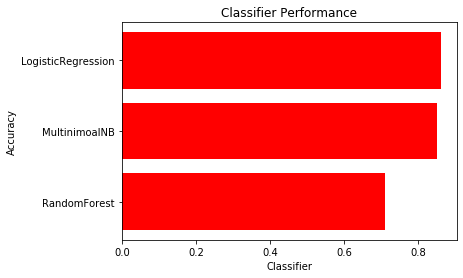

In [8]:
#Calling cross_val function for fashion reviews dataset to assess classifier performance
cross_val(fashion_df)

10 x CV RandomForestClassifier Acc: 0.72
10 x CV MultinomialNB          Acc: 0.87
10 x CV LogisticRegression     Acc: 0.88


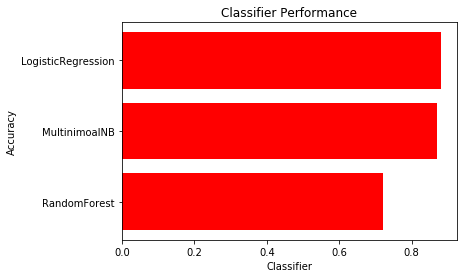

In [9]:
#Calling cross_val function for gym reviews dataset to assess classifier performance
cross_val(gym_df)

10 x CV RandomForestClassifier Acc: 0.80
10 x CV MultinomialNB          Acc: 0.90
10 x CV LogisticRegression     Acc: 0.90


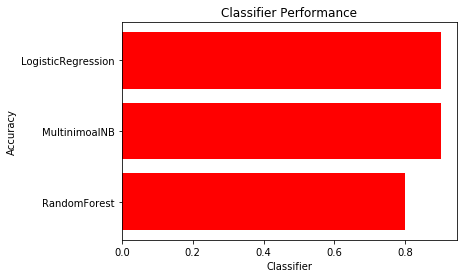

In [10]:
#Calling cross_val function for hair & salon reviews dataset to assess classifier performance
cross_val(hair_salon_df)

# Task 2b, 2c: Building and evaluating classification model

I have defined a function to perform train_test_split on the category dataset and build the model with the classifier passed during function call, predictions made from this classifier are then evaluated using confusion matrix. 

Since our binary classifier predicts all data instances of a test dataset as either positive or negative. Thus the classification produces four outcomes – true positive, true negative, false positive and false negative. The main problem with classification accuracy is that it hides the detail we need to better understand the performance of our classification model so I chose confusion matrix for evaluation because it gives more granular information than just accuracy of the model and summarizes prediction results of our model on classification problem, calculating a confusion matrix gives us a better idea of what our classification model is getting right and what types of errors it is making.

In [13]:
# Function to split the category reviews dataset in training and testing dataset and do prediction.
def train_test(df, classifier):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size = 0.25)
    
    # Logistic Regression Classifier to classify fashion reviews.
    clf = classifier   
    # Fitting the model
    clf_train = clf.fit(X_train, y_train)    
    # Predicting the target for category reviews.
    clf_pred = clf_train.predict(X_test)
    
    # Confusion matrix for the category review dataset
    category_matrix = confusion_matrix(y_test, clf_pred)
    print(classification_report(y_test, clf_pred, target_names=["positive","negative"]))
    fig,ax = plt.subplots(figsize=(5,5))
    sb.heatmap(category_matrix, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Reds')
    sb.set(font_scale= 1.5)
    # Align the text in middle.
    bottom,top = ax.get_ylim()
    ax.set_ylim(bottom +0.5, top - 0.5)

    # Assign labels to X and Y axis.
    #xaxis ticks
    ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
    #yaxis ticks
    ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return clf_train

### Performance of fashion review model

I have used Logistic Regression for fashion review dataset as it performed better amongst all the classifiers while performing cross validation on the fashion dataset above. 

As can be seen from confusion matrix below, out of 500 test reviews, 291 negative reviews (TN) are predicted correctly while 152 positive reviews (TP) are predicted correctly, also there are low number of FNs and FPs as well, that is when classifier falsely predicted the class labels. We can further check F1 score of the model to get measure of model accuracy in terms of Precision and Recall. Thus, the overall performance of the model with fashion dataset is fine as Type I and Type II error are low and overall accuracy of model is 89%.

C:\Users\Aditi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

    positive       0.93      0.77      0.84       197
    negative       0.87      0.96      0.91       303

    accuracy                           0.89       500
   macro avg       0.90      0.87      0.88       500
weighted avg       0.89      0.89      0.88       500



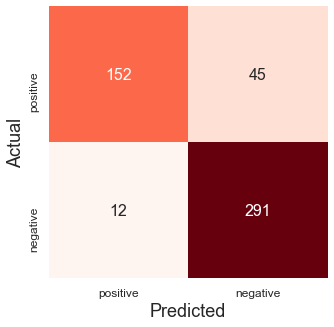

In [14]:
#Calling function to do classifier prediction on the fashion reviews and evaluate classifier performance
clf_fashion = train_test(fashion_df, LogisticRegression())

### Performance of gym review model

I have used Logistic Regression for gym review dataset as it performed better amongst all the classifiers while performing cross validation on the gym dataset above.

As can be seen from confusion matrix below, out of 500 test reviews, 301 negative reviews (TN) are predicted correctly while 149 positive reviews (TP) are predicted correctly, also there are low number of FNs and FPs as well, that is when classifier falsely predicted the class labels. We can further check F1 score of the model to get measure of model accuracy in terms of Precision and Recall. Thus, the overall performance of the model with gym dataset is good as Type I and Type II error are low and the overall accuracy of model is 90%.

C:\Users\Aditi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

    positive       0.93      0.79      0.86       188
    negative       0.89      0.96      0.92       312

    accuracy                           0.90       500
   macro avg       0.91      0.88      0.89       500
weighted avg       0.90      0.90      0.90       500



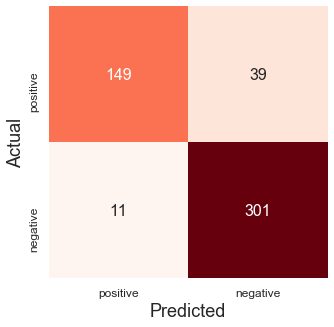

In [15]:
#Calling function to do classifier prediction on the gym reviews and evaluate classifier performance
clf_gym = train_test(gym_df,LogisticRegression())

### Performance of hair & salon review model

I have used Logistic Regression for hair & salon review dataset, though Naive Bayes performed equally good while performing cross validation on the hair & salon dataset above because Naive Bayes assumes that the features are conditionally independent and real data sets are never perfectly independent but they can be close. Thus, Naive Bayes has a higher bias but lower variance compared to logistic regression.

As can be seen from confusion matrix below, out of 500 test reviews, 384 negative reviews (TN) are predicted correctly while 71 positive reviews (TP) are predicted correctly, also there are low number of FNs and FPs as well, that is when classifier falsely predicted the class labels. We can further check F1 score of the model to get measure of model accuracy in terms of Precision and Recall. Thus, the overall performance of the model with gym dataset is good as Type I and Type II error are low and the overall accuracy of model is 91%.

C:\Users\Aditi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

    positive       0.96      0.63      0.76       113
    negative       0.90      0.99      0.94       387

    accuracy                           0.91       500
   macro avg       0.93      0.81      0.85       500
weighted avg       0.91      0.91      0.90       500



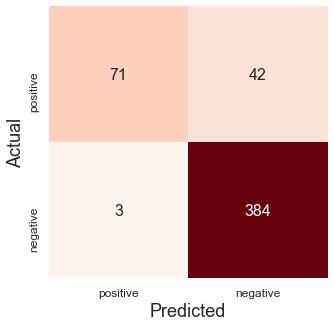

In [16]:
#Calling function to do classifier prediction on the hair & salon reviews and evaluate classifier performance
clf_hair_salon = train_test(hair_salon_df, LogisticRegression())

# Task 3: Classification model performance evaluation on other categories

In [20]:
# Storing rating labels for evaluation on test set
y_fashion_test = fashion_df.iloc[:,-1]
y_gym_test = gym_df.iloc[:,-1]
y_hair_test = hair_salon_df.iloc[:,-1]

In [22]:
# Function to get confusion matrix for performance evaluation of classifier 
def category_conf_matrix(y_test,clf_pred):
   
    category_matrix = confusion_matrix(y_test, clf_pred)
    print(classification_report(y_test, clf_pred, target_names=["positive","negative"]))
    fig,ax = plt.subplots(figsize=(5,5))
    sb.heatmap(category_matrix, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Reds')
    sb.set(font_scale= 1.5)
    # Align the text in middle.
    bottom,top = ax.get_ylim()
    ax.set_ylim(bottom +0.5, top - 0.5)

    #xaxis ticks
    ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
    #yaxis ticks
    ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)   
    # Assign labels to X and Y axis.
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

### Predicting gym and hair salon reviews from classifier trained on fashion reviews dataset

In [23]:
# Re-shaping the gym and hair salon review dataset according to fashion dataset
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df =0.01, stop_words = 'english', use_idf = True)

fashion_vector = tfidf_vectorizer.fit_transform(fashion_reviews['Reviews'])
print(fashion_vector.shape)

# transform will shape the gym dataset according to above fitted and transformed fashion dataset
gym_vector = tfidf_vectorizer.transform(gym_reviews['Reviews'])
print(gym_vector.shape)

# transform will shape the hair & salon dataset according to above fitted and transformed fashion dataset
hair_salon_vector = tfidf_vectorizer.transform(hair_reviews['Reviews'])
print(hair_salon_vector.shape)

(2000, 808)
(2000, 808)
(2000, 808)


### Performance on gym data set of classification model trained on fashion dataset

We can see from the confusion matrix of hair & salon dataset that when predictions are made from model trained on fashion dataset, there are more number of negative reviews which are correctly predicted and the overall accuracy of model is fine with 86% accuracy.

              precision    recall  f1-score   support

    positive       0.90      0.67      0.77       701
    negative       0.84      0.96      0.90      1299

    accuracy                           0.86      2000
   macro avg       0.87      0.81      0.83      2000
weighted avg       0.86      0.86      0.85      2000



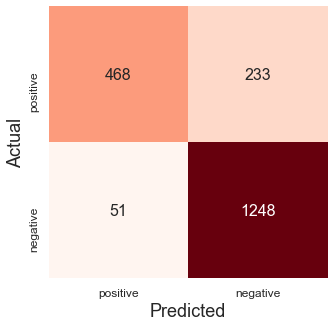

In [24]:
# Using the trained classification model of fashion dataset clf_fashion from Task 2b for evaluating its performance on gym reviews dataset
y_gym_pred = clf_fashion.predict(gym_vector)
category_conf_matrix(y_gym_test, y_gym_pred)

### Performance on hair & salon data set of classification model trained on fashion dataset

We can see from the confusion matrix of hair & salon dataset that when predictions are made from model trained on fashion dataset, there are more number of negative reviews which are correctly predicted and the overall accuracy of model is very good with 91% accuracy.

              precision    recall  f1-score   support

    positive       0.90      0.66      0.76       442
    negative       0.91      0.98      0.94      1558

    accuracy                           0.91      2000
   macro avg       0.91      0.82      0.85      2000
weighted avg       0.91      0.91      0.90      2000



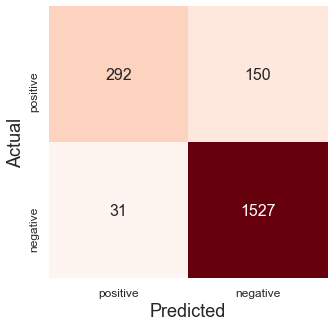

In [25]:
# Using the trained classification model of fashion dataset clf_fashion from Task 2b for evaluating its performance on hair & salon reviews dataset
y_hair_salon_pred = clf_fashion.predict(hair_salon_vector)
category_conf_matrix(y_hair_test, y_hair_salon_pred)

### Predicting fashion and hair salon reviews from classifier trained on gym reviews dataset

In [27]:
# Re-shaping the fashion and hair salon review dataset according to gym dataset
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df =0.01, stop_words = 'english', use_idf = True)

gym_vector = tfidf_vectorizer.fit_transform(gym_reviews['Reviews'])
print(gym_vector.shape)

# transform will shape the fashion dataset according to above fitted and transformed gym dataset
fashion_vector = tfidf_vectorizer.transform(fashion_reviews['Reviews'])
print(fashion_vector.shape)

# transform will shape the hair & salon dataset according to above fitted and transformed gym dataset
hair_salon_vector = tfidf_vectorizer.transform(hair_reviews['Reviews'])
print(hair_salon_vector.shape)

(2000, 969)
(2000, 969)
(2000, 969)


### Performance on fashion data set of classification model trained on gym dataset

We can see from the confusion matrix of fashion dataset that when predictions are made from model trained on gym dataset that the overall accuracy of model is fine with 85% accuracy. Also, there are quite considerate number of falsely predicted labels.

              precision    recall  f1-score   support

    positive       0.85      0.76      0.80       795
    negative       0.85      0.91      0.88      1205

    accuracy                           0.85      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.85      0.85      2000



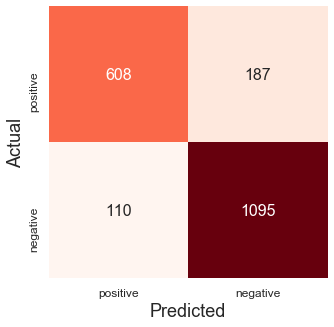

In [28]:
# Using the trained classification model of gym dataset clf_gym from Task 2b for evaluating its performance on fashion reviews dataset
y_fashion_pred = clf_gym.predict(fashion_vector)
category_conf_matrix(y_fashion_test, y_fashion_pred)

### Performance on hair & salon data set of classification model trained on gym dataset

We can see from the confusion matrix of hair & salon dataset that when predictions are made from model trained on gym dataset that the overall accuracy of model is quite good with 92% accuracy. Also, there are quite considerate number of falsely predicted labels.

              precision    recall  f1-score   support

    positive       0.80      0.83      0.81       442
    negative       0.95      0.94      0.95      1558

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.92      0.92      0.92      2000



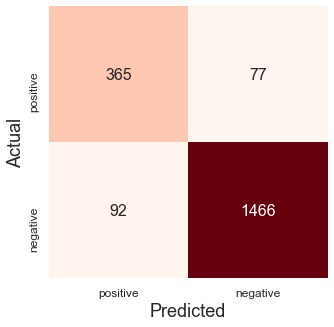

In [29]:
# Using the trained classification model of gym dataset clf_gym from Task 2b for evaluating its performance on hair & salon reviews dataset
y_hair_salon_pred = clf_gym.predict(hair_salon_vector)
category_conf_matrix(y_hair_test, y_hair_salon_pred)

### Predicting fashion and gym reviews from classifier trained on hair & salon reviews dataset

In [30]:
# Re-shaping the fashion and gym review dataset according to hair & salon dataset
tfidf_vectorizer = TfidfVectorizer(max_df = 0.5, min_df =0.01, stop_words = 'english', use_idf = True)

hair_salon_vector = tfidf_vectorizer.fit_transform(hair_reviews['Reviews'])
print(hair_salon_vector.shape)

# transform will shape the gym dataset according to above fitted and transformed hair & salon dataset
gym_vector = tfidf_vectorizer.transform(gym_reviews['Reviews'])
print(gym_vector.shape)

# transform will shape the fashion dataset according to above fitted and transformed hair & salon dataset
fashion_vector = tfidf_vectorizer.transform(fashion_reviews['Reviews'])
print(fashion_vector.shape)


(2000, 734)
(2000, 734)
(2000, 734)


### Performance on fashion data set of classification model trained on hair & salon dataset

We can see from the confusion matrix of fashion dataset that when predictions are made from model trained on hair & salon dataset that the overall accuracy of model is not that good with 79% accuracy. Also, there are quite high number of falsely predicted negative labels, i.e the precision for negative reviews prediction is quite low.

              precision    recall  f1-score   support

    positive       0.94      0.49      0.65       795
    negative       0.75      0.98      0.85      1205

    accuracy                           0.79      2000
   macro avg       0.84      0.74      0.75      2000
weighted avg       0.82      0.79      0.77      2000



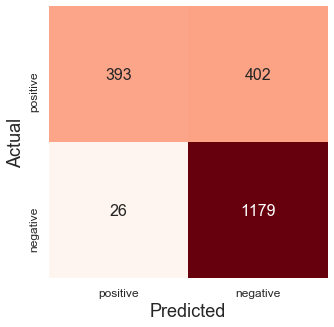

In [31]:
# Using the trained classification model of hair & salon dataset clf_hair_salon from Task 2b for evaluating its performance on fashion reviews dataset
y_fashion_pred = clf_hair_salon.predict(fashion_vector)
category_conf_matrix(y_fashion_test, y_fashion_pred)

### Performance on gym data set of classification model trained on hair & salon dataset

We can see from the confusion matrix of fashion dataset that when predictions are made from model trained on hair & salon dataset that the overall accuracy of model is bad with 61% accuracy. Also, there are quite high number of falsely predicted  labels, i.e the precision for both negative and positive reviews prediction is quite low. 

              precision    recall  f1-score   support

    positive       0.37      0.17      0.23       701
    negative       0.65      0.85      0.74      1299

    accuracy                           0.61      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.55      0.61      0.56      2000



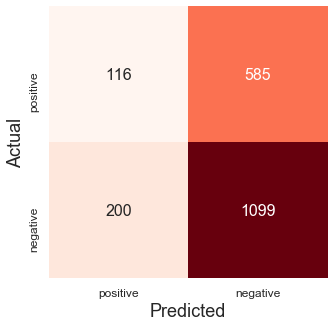

In [32]:
# Using the trained classification model of hair & salon dataset clf_hair_salon from Task 2b for evaluating its performance on gym reviews dataset
y_gym_pred = clf_hair_salon.predict(hair_salon_vector)
category_conf_matrix(y_gym_test, y_gym_pred)

# Conclusion

As we can see from the results above, we can say that since prediction of model trained on fashion dataset and hair & salon dataset worked more acurately for each other while they are not that good for gym dataset as fashion and gym are not much related categories, so the predictions made on the gym dataset will not be as accurate as those made on hair & salon dataset. This means that consumers have used more or less same words in writing reviews for fashion and hair & salon dataset. Thus for related categories, consumers have used same words, thus they are more accuratey predicted than those which are less related to each other. 

Also, the negative responses are predicted correctly most of the times as can be seen from confusion matrix of categories above as compared to positive responses which are falsely predicted quite a few number of times thus, we might need to collect more data of positive reviews to increase number of features with positive ratings and improve the results.